<a href="https://colab.research.google.com/github/heugyu/coin_deep_learning/blob/master/DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# GEN DATASET

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 10)

1.4.0
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [98]:
# 구글 드라이브 csv read
data = pd.read_csv('/content/drive/My Drive/DATA/COINBASE_BTCUSD_30.csv')
print(f'데이터 shape : {data.shape}')
print(data.columns)
data = data.set_index('time')
data.head()

데이터 shape : (20700, 69)
Index(['time', 'open', 'high', 'low', 'close', 'H', 'M', 'L', 'wca', 'RES',
       'SUP', 'Shapes', 'Shapes.1', 'EMA_34', 'EMA_90', 'EMA_100', 'EMA_144',
       'EMA_200', 'Mean ', 'Upper ', 'Lower', 'Upper fib ', 'low fib', 'Plot',
       'Plot.1', 'Plot.2', 'ParabolicSAR', 'short_line', 'RES.1', 'RES_CLOSE',
       'SUP.1', 'SUP_CLOSE', 'VWAP', '34 EMA', 'Volume', 'Volume MA',
       'Bitfinex (USD)', 'Coinbase (USD)', 'Bitstamp (USD)', 'Kraken   (USD)',
       'HitBTC   (USD)', 'Binance  (USDT)', 'Bittrex  (USDT)',
       'Kraken   (EUR)', 'Bitstamp (EUR)', 'Coinbase (EUR)', 'Volume.1',
       'A/D Volume', 'Volume EMA', 'A/D Volume EMA', 'A/D Buy MA',
       'A/D Sell MA', 'OnBalanceVolume', 'MF', 'Accumulation/Distribution',
       'RSI', 'EMA of RSI', 'EMA of EMA of RSI', 'Stoch K', 'Stoch D', 'T',
       'Second RSI', 'Second MFI', 'BB Basis', 'BB Upper', 'BB Lower',
       'Plot.3', 'Plot.4', 'CCI'],
      dtype='object')


,open,high,low,close,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),Binance (USDT),Bittrex (USDT),Kraken (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA,OnBalanceVolume,MF,Accumulation/Distribution,RSI,EMA of RSI,EMA of EMA of RSI,Stoch K,Stoch D,T,Second RSI,Second MFI,BB Basis,BB Upper,BB Lower,Plot.3,Plot.4,CCI
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1546300800,3691.87,3692.33,3680.63,3685.00,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3685.986667,3772.572235,189.79030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.995645e+05,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-48.015324,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546302600,3685.00,3701.73,3684.78,3691.89,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3680.6300,NaN,0.0,0.0,0.0,0.0,3690.569496,3772.572235,389.94630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.439994e+06,578829.324667,NaN,NaN,NaN,NaN,389.94630,NaN,-110.820834,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546304400,3691.89,3693.67,3682.64,3687.49,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3680.6300,NaN,0.0,0.0,0.0,0.0,3689.612565,3772.572235,330.37030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.218384e+06,537576.342370,NaN,NaN,NaN,NaN,59.57600,NaN,-150.656963,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546306200,3687.49,3687.50,3666.40,3676.66,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3701.7300,NaN,0.0,0.0,0.0,0.0,3685.686632,3767.091536,404.49430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.487266e+06,780990.979393,NaN,NaN,NaN,NaN,-344.91830,NaN,-161.775763,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1546308000,3676.66,3679.00,3666.40,3674.00,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3701.0234,NaN,0.0,0.0,0.0,0.0,3684.161565,3767.091536,181.79297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.677498e+05,197145.184324,NaN,NaN,NaN,NaN,-526.71127,NaN,-124.262928,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:

copy_data = data[['open', 'high', 'low', 'close', 
                  'Mean ', 'Upper ', 'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 'Plot.2',
                  'ParabolicSAR',
                  'H', 'M', 'L', 'RES', 'SUP','EMA_34', 
                  'short_line', 'VWAP', '34 EMA', 'Volume.1', 'A/D Volume', 
                  'OnBalanceVolume', 'MF', 'Accumulation/Distribution', 'RSI', 
                  'Second RSI', 'Second MFI', 'BB Basis', 'BB Upper', 'BB Lower',
                  'Plot.3', 'Plot.4', 'CCI']].dropna()

# hlc  (high + low + close) / 3
copy_data['hlc3'] =(copy_data.high + copy_data.low + copy_data.close) /3

# 봉별 체인지 (close - open) / open
copy_data['change'] = ((copy_data.close - copy_data.open) / copy_data.open)

#   결측치 있는지 확인 
print(copy_data.shape)
print(copy_data.isna().sum())

(20501, 38)
open                         0
high                         0
low                          0
close                        0
Mean                         0
Upper                        0
Lower                        0
Upper fib                    0
low fib                      0
Plot                         0
Plot.1                       0
Plot.2                       0
ParabolicSAR                 0
H                            0
M                            0
L                            0
RES                          0
SUP                          0
EMA_34                       0
short_line                   0
VWAP                         0
34 EMA                       0
Volume.1                     0
A/D Volume                   0
OnBalanceVolume              0
MF                           0
Accumulation/Distribution    0
RSI                          0
Second RSI                   0
Second MFI                   0
BB Basis                     0
BB Upper                   

#### 데이터 분석 Chart
- close에 연관이 있는 feature
- 상승/하락에 연관있는 feature
- open -> hlc3 (high + low + close)

In [100]:
copy_data.head()

,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution,RSI,Second RSI,Second MFI,BB Basis,BB Upper,BB Lower,Plot.3,Plot.4,CCI,hlc3,change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1546657200,3842.98,3844.73,3835.55,3838.00,3805.785,3881.57,3730.0,3845.79948,3765.77052,3874.323291,3820.527064,3766.730837,3791.634857,3858.940395,3806.205952,3753.471508,3841.17,0.0,3807.879366,3808.272976,3789.790287,3799.515989,322052.260628,125125.605981,-1203.13784,-0.002836,1262.323092,62.500521,-1.307678,-10.171734,65.490242,72.694728,58.285756,72.694728,58.285756,60.115149,3839.426667,-0.001296
1546659000,3837.99,3848.01,3837.99,3844.41,3805.785,3881.57,3730.0,3845.79948,3765.77052,3873.431079,3820.018854,3766.606629,3796.583966,3859.183696,3806.822262,3754.460828,3841.17,0.0,3809.966830,3810.896772,3789.897271,3802.081361,311967.926001,125887.256899,-1121.96954,-0.018083,1285.166865,64.673897,-1.234156,-10.321703,66.093195,71.207268,60.979123,71.207268,60.979123,68.863313,3843.470000,0.001673
1546660800,3844.41,3850.00,3842.00,3848.33,3805.785,3881.57,3730.0,3845.79948,3765.77052,3872.505558,3819.489591,3766.473623,3801.236128,3859.396020,3807.428489,3755.460958,3841.17,0.0,3812.159012,3813.446839,3790.058944,3802.081361,446577.304043,184585.285671,-1005.87824,0.002141,1352.790048,65.972719,-0.441932,-7.037721,66.315511,71.108632,61.522390,71.108632,61.522390,74.139238,3846.776667,0.001020
1546662600,3848.33,3849.85,3845.00,3845.01,3805.785,3881.57,3730.0,3845.79948,3765.77052,3871.546450,3818.939274,3766.332098,3805.609160,3859.594824,3808.026070,3756.457315,3841.17,0.0,3814.036211,3815.898925,3790.155686,3802.081361,269176.081726,8695.034942,-1075.85554,0.026993,1283.101314,63.832146,-1.227421,-9.668780,65.816010,70.050097,61.581924,70.050097,61.581924,64.119139,3846.620000,-0.000863
1546664400,3845.00,3861.36,3845.00,3857.87,3805.785,3881.57,3730.0,3845.79948,3765.77052,3870.553462,3818.367904,3766.182346,3809.719810,3860.036118,3808.759793,3757.483468,3841.17,0.0,3816.540999,3818.466734,3790.419106,3802.081361,645847.982950,320686.946709,-908.30924,0.028532,1379.163923,68.143829,0.682546,-10.258261,66.008129,70.400241,61.616016,70.400241,61.616016,99.267241,3854.743333,0.003347


In [0]:
#   스케일러 설정 
"""
    open, high, low, close, Mean, Upper, Lower, Upper fib,
    low fib, Plot, Plot.1, Plot.2, ParabolicSAR, H, M, L, 
    RES, SUP, EMA_34, short_line, VWAP, 34 EMA, hlc3
"""
price_scaler = MinMaxScaler()
""" Volume.1, A/D Volume """
vol_scaler = MinMaxScaler()
""" OnBalanceVolume """
obv_scaler = MinMaxScaler()
""" MF """
mf_scaler = MinMaxScaler()
""" Accumulation/Distribution """
ad_scaler = MinMaxScaler()
""" RSI """
rsi_scaler = MinMaxScaler()
""" Second RSI """
rsi2_scaler = MinMaxScaler()
""" Second MFI """
mfi_scaler = MinMaxScaler()
""" BB Basis, BB Upper, BB Lower """
bb_scaler = MinMaxScaler()
""" Plot.3, Plot.4, CCI """
cci_scaler = MinMaxScaler()

#   스케일 데이터 fitting
price_scaler.fit(np.array(copy_data[['open', 'high', 'low', 'close', 'Mean ', 'Upper ', 
                                     'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 
                                     'Plot.2', 'ParabolicSAR', 'H', 'M', 'L', 'RES', 'SUP', 
                                     'EMA_34', 'short_line', 'VWAP', '34 EMA', 'hlc3']]).reshape(-1, 1))
vol_scaler.fit(np.array(copy_data[['Volume.1', 'A/D Volume']]).reshape(-1, 1))
obv_scaler.fit(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
mf_scaler.fit(np.array(copy_data[['MF']]).reshape(-1, 1))
ad_scaler.fit(np.array(copy_data[['Accumulation/Distribution']]).reshape(-1, 1))
rsi_scaler.fit(np.array(copy_data[['RSI']]).reshape(-1, 1))
rsi2_scaler.fit(np.array(copy_data[['Second RSI']]).reshape(-1, 1))
mfi_scaler.fit(np.array(copy_data[['Second MFI']]).reshape(-1, 1))
bb_scaler.fit(np.array(copy_data[['BB Basis', 'BB Upper', 'BB Lower']]).reshape(-1, 1))
cci_scaler.fit(np.array(copy_data[['Plot.3', 'Plot.4', 'CCI']]).reshape(-1, 1))


#   학습데이터 0 ~ 1 스케일 
copy_data[['open', 'high', 'low', 'close', 'Mean ', 'Upper ', 
           'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 
           'Plot.2', 'ParabolicSAR', 'H', 'M', 'L', 'RES', 'SUP', 
           'EMA_34', 'short_line', 'VWAP', '34 EMA', 'hlc3']] = price_scaler.transform(np.array(copy_data[['open', 'high', 'low', 'close', 'Mean ', 
                                                                                                   'Upper ', 'Lower', 'Upper fib ', 'low fib', 
                                                                                                   'Plot', 'Plot.1', 'Plot.2', 'ParabolicSAR', 
                                                                                                   'H', 'M', 'L', 'RES', 'SUP', 'EMA_34', 'short_line', 
                                                                                                   'VWAP', '34 EMA', 'hlc3']]).reshape(-1, 23))
copy_data[['Volume.1', 'A/D Volume']] = vol_scaler.transform(np.array(copy_data[['Volume.1', 'A/D Volume']]).reshape(-1, 2))
copy_data[['OnBalanceVolume']] = obv_scaler.transform(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
copy_data[['MF']] = mf_scaler.transform(np.array(copy_data[['MF']]).reshape(-1, 1))
copy_data[['Accumulation/Distribution']] = ad_scaler.transform(np.array(copy_data[['Accumulation/Distribution']]).reshape(-1, 1))
copy_data[['RSI']] = rsi_scaler.transform(np.array(copy_data[['RSI']]).reshape(-1, 1))
copy_data[['Second RSI']] = rsi2_scaler.transform(np.array(copy_data[['Second RSI']]).reshape(-1, 1))
copy_data[['Second MFI']] = mfi_scaler.transform(np.array(copy_data[['Second MFI']]).reshape(-1, 1))
copy_data[['BB Basis', 'BB Upper', 'BB Lower']] = bb_scaler.transform(np.array(copy_data[['BB Basis', 'BB Upper', 'BB Lower']]).reshape(-1, 3))
copy_data[['Plot.3', 'Plot.4', 'CCI']] = cci_scaler.transform(np.array(copy_data[['Plot.3', 'Plot.4', 'CCI']]).reshape(-1, 3))


In [102]:
copy_data.head()

,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution,RSI,Second RSI,Second MFI,BB Basis,BB Upper,BB Lower,Plot.3,Plot.4,CCI,hlc3,change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1546657200,0.277103,0.277229,0.276567,0.276743,0.274421,0.279885,0.268956,0.277306,0.271535,0.279363,0.275484,0.271605,0.273400,0.278253,0.274451,0.270648,0.276972,0.0,0.274572,0.274600,0.273267,0.273969,0.002649,0.001029,0.413158,0.429879,0.001790,0.602847,0.490440,0.360974,0.657144,0.717072,0.597215,0.547169,0.536143,0.537543,0.276846,-0.001296
1546659000,0.276743,0.277465,0.276743,0.277206,0.274421,0.279885,0.268956,0.277306,0.271535,0.279298,0.275447,0.271596,0.273757,0.278271,0.274495,0.270720,0.276972,0.0,0.274722,0.274789,0.273275,0.274153,0.002566,0.001035,0.413798,0.417899,0.001875,0.626567,0.492048,0.358760,0.662159,0.704699,0.619619,0.546031,0.538204,0.544237,0.277138,0.001673
1546660800,0.277206,0.277609,0.277032,0.277488,0.274421,0.279885,0.268956,0.277306,0.271535,0.279232,0.275409,0.271586,0.274093,0.278286,0.274539,0.270792,0.276972,0.0,0.274880,0.274973,0.273287,0.274153,0.003673,0.001518,0.414712,0.433790,0.002125,0.640743,0.509369,0.407254,0.664009,0.703879,0.624138,0.545955,0.538620,0.548275,0.277376,0.001020
1546662600,0.277488,0.277598,0.277248,0.277249,0.274421,0.279885,0.268956,0.277306,0.271535,0.279162,0.275369,0.271576,0.274408,0.278301,0.274582,0.270864,0.276972,0.0,0.275016,0.275150,0.273294,0.274153,0.002214,0.000072,0.414161,0.453318,0.001867,0.617380,0.492195,0.368402,0.659854,0.695074,0.624633,0.545145,0.538665,0.540607,0.277365,-0.000863
1546664400,0.277248,0.278428,0.277248,0.278176,0.274421,0.279885,0.268956,0.277306,0.271535,0.279091,0.275328,0.271565,0.274704,0.278332,0.274635,0.270938,0.276972,0.0,0.275196,0.275335,0.273313,0.274153,0.005312,0.002638,0.415481,0.454528,0.002222,0.664439,0.533955,0.359697,0.661452,0.697986,0.624917,0.545413,0.538692,0.567503,0.277951,0.003347


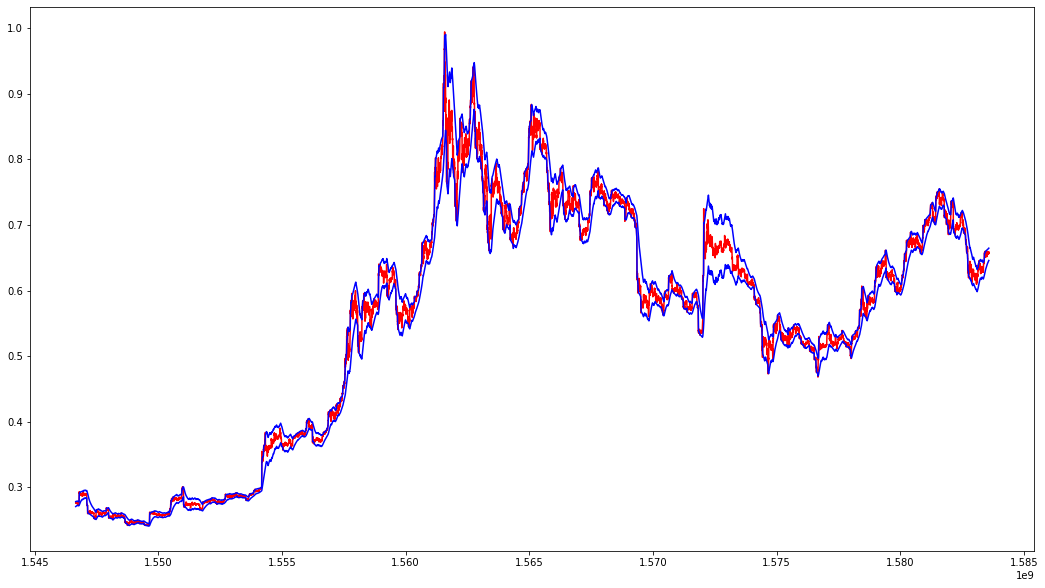

In [103]:
# 스케일 후 plot
plt.plot(copy_data.hlc3, 'r')
plt.plot(copy_data.H, color='b')
plt.plot(copy_data.L, color='b')

In [104]:
# 컬럼별 상관관계
copy_data.corr()

,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution,RSI,Second RSI,Second MFI,BB Basis,BB Upper,BB Lower,Plot.3,Plot.4,CCI,hlc3,change
open,1.000000,0.999890,0.999833,0.999834,0.996427,0.993749,0.992645,0.995676,0.995384,0.993638,0.994618,0.992404,0.998005,0.996297,0.997741,0.996119,0.967481,0.902166,0.998858,0.998818,0.798829,0.995027,0.302081,0.201425,0.158147,-0.014516,0.839262,0.002675,-0.005546,-0.002986,0.009363,0.015589,0.001196,0.015589,0.001196,-0.012602,0.999903,-0.012371
high,0.999890,1.000000,0.999747,0.999902,0.996355,0.994070,0.992131,0.995818,0.995085,0.993652,0.994438,0.992017,0.997823,0.996448,0.997645,0.995752,0.967437,0.900969,0.998746,0.998709,0.797263,0.994890,0.309345,0.207697,0.160786,-0.012800,0.837963,0.006131,-0.002432,-0.001333,0.010070,0.017008,0.001043,0.017008,0.001043,-0.008213,0.999935,-0.002613
low,0.999833,0.999747,1.000000,0.999891,0.996270,0.993143,0.992995,0.995275,0.995488,0.993301,0.994521,0.992561,0.997697,0.995812,0.997544,0.996240,0.967384,0.903562,0.998665,0.998588,0.800741,0.994905,0.290360,0.192258,0.154941,-0.013458,0.840889,0.006866,-0.001244,-0.000805,0.009799,0.014962,0.002609,0.014962,0.002609,-0.007270,0.999930,-0.000907
close,0.999834,0.999902,0.999891,1.000000,0.996317,0.993648,0.992526,0.995571,0.995270,0.993488,0.994470,0.992259,0.997754,0.996156,0.997597,0.995973,0.967363,0.902073,0.998716,0.998660,0.798695,0.994878,0.300267,0.200334,0.158379,-0.011452,0.839181,0.008060,-0.000541,-0.000902,0.010024,0.016157,0.001814,0.016157,0.001814,-0.005551,0.999982,0.005168
Mean,0.996427,0.996355,0.996270,0.996317,1.000000,0.997152,0.996385,0.999159,0.999046,0.998499,0.999299,0.996877,0.995958,0.997942,0.999381,0.997748,0.973536,0.908498,0.998355,0.997851,0.808131,0.999031,0.299403,0.199749,0.144362,-0.037144,0.846670,-0.042611,-0.006230,-0.003664,-0.044121,-0.032279,-0.046943,-0.032279,-0.046943,-0.036720,0.996365,-0.009322
Upper,0.993749,0.994070,0.993143,0.993648,0.997152,1.000000,0.987141,0.999406,0.992909,0.997176,0.995099,0.989628,0.993193,0.998375,0.996624,0.991500,0.971396,0.893199,0.995497,0.995174,0.789463,0.995732,0.328069,0.220610,0.172670,-0.032448,0.830440,-0.039931,-0.006956,-0.004144,-0.040399,-0.027067,-0.045478,-0.027067,-0.045478,-0.034922,0.993673,-0.008517
Lower,0.992645,0.992131,0.992995,0.992526,0.996385,0.987141,1.000000,0.992066,0.999144,0.993178,0.997212,0.998242,0.992279,0.990645,0.995668,0.997979,0.969306,0.919533,0.994762,0.994059,0.823645,0.995931,0.265069,0.174886,0.111490,-0.042180,0.859175,-0.045340,-0.005371,-0.003099,-0.048014,-0.037930,-0.048272,-0.037930,-0.048272,-0.038494,0.992600,-0.010166
Upper fib,0.995676,0.995818,0.995275,0.995571,0.999159,0.999406,0.992066,1.000000,0.996417,0.998486,0.997723,0.993642,0.995160,0.998883,0.998589,0.995058,0.973062,0.900824,0.997508,0.997102,0.798555,0.997944,0.315196,0.211229,0.159851,-0.034617,0.838447,-0.041185,-0.006629,-0.003928,-0.042129,-0.029469,-0.046180,-0.029469,-0.046180,-0.035769,0.995607,-0.008891
low fib,0.995384,0.995085,0.995488,0.995270,0.999046,0.992909,0.999144,0.996417,1.000000,0.996667,0.999130,0.998480,0.994968,0.995094,0.998376,0.998769,0.972242,0.914991,0.997411,0.996805,0.816835,0.998341,0.282027,0.187151,0.127597,-0.039766,0.853863,-0.044052,-0.005794,-0.003377,-0.046162,-0.035212,-0.047669,-0.035212,-0.047669,-0.037665,0.995331,-0.009764
Plot,0.993638,0.993652,0.993301,0.993488,0.998499,0.997176,0.993178,0.998486,0.996667,1.000000,0.998511,0.993654,0.993412,0.997508,0.997838,0.994994,0.972215,0.902440,0.996454,0.995958,0.800861,0.997573,0.306872,0.204853,0.153384,-0.040340,0.840133,-0.054793,-0.005313,-0.002307,-0.058651,-0.045146,-0.060157,-0.045146,-0.060157,-0.042823,0.993532,-0.011641


In [105]:
# ML 테스트는 label 값이 존재 해야함 
# 해당 봉의 feature 값은 다음봉의 가격 변동과 관련있다
true_close = copy_data.close.iloc[1:, ]
copy_data = copy_data.iloc[1:, ]
copy_data['true_close'] = true_close

print(copy_data.shape)
copy_data.head()

(20500, 39)


,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution,RSI,Second RSI,Second MFI,BB Basis,BB Upper,BB Lower,Plot.3,Plot.4,CCI,hlc3,change,true_close
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1546659000,0.276743,0.277465,0.276743,0.277206,0.274421,0.279885,0.268956,0.277306,0.271535,0.279298,0.275447,0.271596,0.273757,0.278271,0.274495,0.270720,0.276972,0.0,0.274722,0.274789,0.273275,0.274153,0.002566,0.001035,0.413798,0.417899,0.001875,0.626567,0.492048,0.358760,0.662159,0.704699,0.619619,0.546031,0.538204,0.544237,0.277138,0.001673,0.277206
1546660800,0.277206,0.277609,0.277032,0.277488,0.274421,0.279885,0.268956,0.277306,0.271535,0.279232,0.275409,0.271586,0.274093,0.278286,0.274539,0.270792,0.276972,0.0,0.274880,0.274973,0.273287,0.274153,0.003673,0.001518,0.414712,0.433790,0.002125,0.640743,0.509369,0.407254,0.664009,0.703879,0.624138,0.545955,0.538620,0.548275,0.277376,0.001020,0.277488
1546662600,0.277488,0.277598,0.277248,0.277249,0.274421,0.279885,0.268956,0.277306,0.271535,0.279162,0.275369,0.271576,0.274408,0.278301,0.274582,0.270864,0.276972,0.0,0.275016,0.275150,0.273294,0.274153,0.002214,0.000072,0.414161,0.453318,0.001867,0.617380,0.492195,0.368402,0.659854,0.695074,0.624633,0.545145,0.538665,0.540607,0.277365,-0.000863,0.277249
1546664400,0.277248,0.278428,0.277248,0.278176,0.274421,0.279885,0.268956,0.277306,0.271535,0.279091,0.275328,0.271565,0.274704,0.278332,0.274635,0.270938,0.276972,0.0,0.275196,0.275335,0.273313,0.274153,0.005312,0.002638,0.415481,0.454528,0.002222,0.664439,0.533955,0.359697,0.661452,0.697986,0.624917,0.545413,0.538692,0.567503,0.277951,0.003347,0.278176
1546666200,0.278177,0.278330,0.277982,0.278312,0.274421,0.279885,0.268956,0.277306,0.271535,0.279017,0.275285,0.271554,0.274983,0.278343,0.274678,0.271013,0.276972,0.0,0.275374,0.275532,0.273322,0.274391,0.002412,0.001779,0.416079,0.469232,0.002474,0.670845,0.558961,0.450235,0.662925,0.701285,0.624566,0.545717,0.538659,0.572158,0.278208,0.000485,0.278312


In [0]:
#   하이퍼 파라미터 설정 
EPOCHS = 1000
INPUT_SIZE = 39     # input dimension
HIDDEN_SIZE = 128   # hidden dimension
OUTPUT_SIZE = 3     # out dimension
BATCH_SIZE = 128    # batch size
NUM_LAYERS = 1      # LSTM layers 
LENGTH = 14         # input <-> output length
DROPOUT = 0.6
LR = 0.005
L2 = 0.00001

In [0]:
class BTCDataset(Dataset):
    def __init__(self, data, input_length, output_length):
        self.data = data
        self.input_length = input_length
        self.output_length= output_length
    
    def __len__(self):
        return len(self.data) - (self.input_length + self.output_length) + 1

    def __getitem__(self, idx):
        idx += self.input_length 
        data = self.data.iloc[idx - self.input_length : idx + self.output_length]
        # data = data.apply(lambda x: np.log(x + 1) - np.log(x[self.x_frames -1] + 1))
        data = data.values
        X = data[: self.input_length ]
        y = data[self.input_length : ]
        return X, y

In [0]:
# LSTM 

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.dropout = dropout

        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()

    def init_hidden(self):
        return(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
               torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
    def make_regressor(self):
        layers = []
        layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))

        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        
        regressor = nn.Sequential(*layers)
        return regressor

    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
def train(model, partition, optimizer, loss_fn):
    trainloader = DataLoader(partition,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             drop_last=True)   
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0

    for i, (X, y) in enumerate(trainloader):
        X = X.transpose(0, 1).float().to("cuda")
        y_true = y[:, :, 37].float().to("cuda")

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to("cuda") for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / len(trainloader)
    return model, train_loss

In [52]:
train_size = int(len(copy_data) * 0.8)

train_data = BTCDataset(copy_data[:train_size], LENGTH, OUTPUT_SIZE)
test_data = BTCDataset(copy_data[train_size:], LENGTH, OUTPUT_SIZE)

model = LSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUM_LAYERS, BATCH_SIZE, DROPOUT)
model.to("cuda")
loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=L2)

for epoch in range(EPOCHS):
    model, train_loss = train(model, train_data, optimizer, loss_fn)
    if epoch%100 == 0:
        print(f'Epoch {epoch}, Loss {train_loss}')


Epoch 0, Loss 0.015767984489912124
Epoch 100, Loss 2.9441320357648237e-05
Epoch 200, Loss 2.9427669566928216e-05
Epoch 300, Loss 2.9320969161972243e-05
Epoch 400, Loss 2.9656293691004976e-05
Epoch 500, Loss 2.9445475036027347e-05
Epoch 600, Loss 2.9794155977924675e-05
Epoch 700, Loss 2.955794693093594e-05
Epoch 800, Loss 2.9601052766281555e-05
Epoch 900, Loss 2.926360029675834e-05


In [0]:
def metric(y_pred, y_true):
    perc_y_pred = y_pred.cpu().detach().numpy()
    perc_y_true = y_true.cpu().detach().numpy()
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [0]:
train_size = int(len(copy_data) * 0.8)

train_data = BTCDataset(copy_data[:train_size], LENGTH, OUTPUT_SIZE)
test_data = BTCDataset(copy_data[train_size:], LENGTH, OUTPUT_SIZE)

In [111]:
# 테스트 데이터 분석
# dataset은 train, test에서 사용할 수 있게 입력 및 출력 데이터 생성 
# DataLoader는 dataset을 입력으러 받아 배치 사이즈 큼 셔플을 하거나 드롭을하는 기능 제공 
# dataset을 load하여 핸들링이 쉽게

testloader = DataLoader(test_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        drop_last=True)

for i,(X, y) in enumerate(testloader):
    if i < 10:
        X = X.transpose(0, 1).float().to('cuda')
        y_true = y[:, :, 37].float().to('cuda')
        print(i)
        print(torch.max(X[:, :, 37]), torch.max(y_true))

0
tensor(0.0099, device='cuda:0') tensor(0.0099, device='cuda:0')
1
tensor(0.0252, device='cuda:0') tensor(0.0252, device='cuda:0')
2
tensor(0.0387, device='cuda:0') tensor(0.0387, device='cuda:0')
3
tensor(0.0100, device='cuda:0') tensor(0.0100, device='cuda:0')
4
tensor(0.0123, device='cuda:0') tensor(0.0134, device='cuda:0')
5
tensor(0.0145, device='cuda:0') tensor(0.0145, device='cuda:0')
6
tensor(0.0063, device='cuda:0') tensor(0.0063, device='cuda:0')
7
tensor(0.0277, device='cuda:0') tensor(0.0277, device='cuda:0')
8
tensor(0.0125, device='cuda:0') tensor(0.0125, device='cuda:0')
9
tensor(0.0229, device='cuda:0') tensor(0.0229, device='cuda:0')


In [0]:
def test(model, partition):
    pred_close = []
    real_close = []
    abs_close = []
    testloader = DataLoader(partition,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            drop_last=True)
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X = X.transpose(0, 1).float().to('cuda')
            y_true = y[:, :, 37].float().to('cuda')
            model.hidden = [hidden.to('cuda') for hidden in model.init_hidden()]
            y_pred = model(X)
            # print(f'predict : {y_pred[0].item()}')
            # print(f'real : {y_true[0].item()}')
            print(f' predeict : {y_pred.view(-1)}')
            print(f' true :  {y_true.view(-1)}')
            # pred_close.append(price_scaler.inverse_transform(np.array(y_pred[0].item()).reshape(-1, 1)).reshape(-1)[0])
            # real_close.append(price_scaler.inverse_transform(np.array(y_true[0].item()).reshape(-1, 1)).reshape(-1)[0])
            # abs_close.append(
            #     np.abs(
            #         price_scaler.inverse_transform(np.array(y_pred[0].item()).reshape(-1, 1)).reshape(-1)[0] 
            #         - price_scaler.inverse_transform(np.array(y_true[0].item()).reshape(-1, 1)).reshape(-1)[0]
            #     )
            # )
            test_acc += metric(y_pred, y_true)[0]
    test_acc = test_acc / len(testloader)
    return abs_close, pred_close, real_close, test_acc        

In [74]:
abs_close, pred_close, real_close, acc = test(model, test_data)
np.average(abs_close)

 predeict : tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.00

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

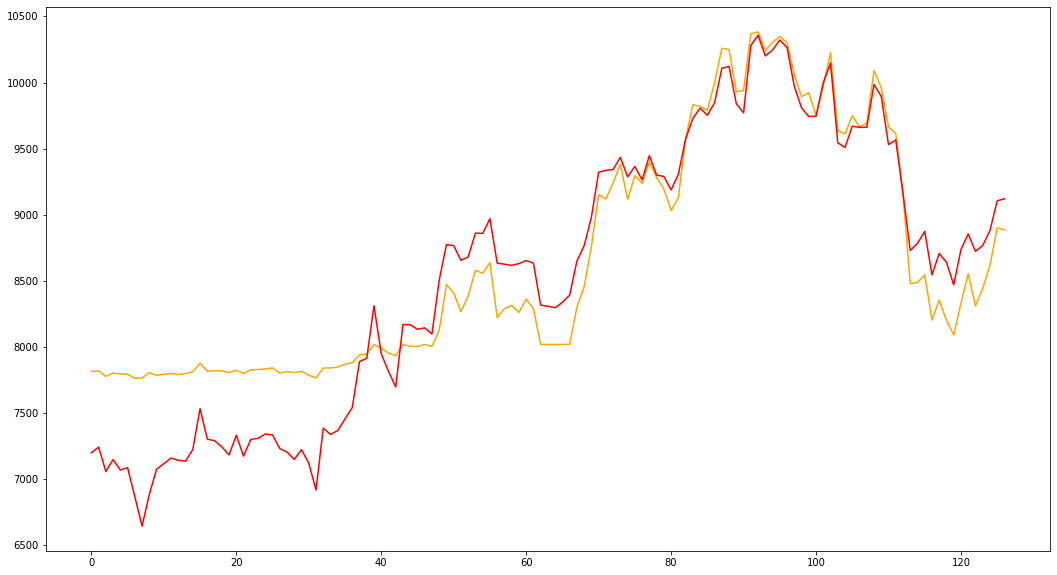

In [100]:
plt.plot(pred_close, 'orange')
plt.plot(real_close, 'r')

In [0]:
# feature data scale
copy_data.describe()

# change -> open과 hlc3를 비교 
# change 변화량이 -0.02 보다 작으면 약세라 생각 라벨 0
# change 변화량이 -0.02 ~ 0.02 -> 보합이라 생각 라벨 1
# change 변화량이 0.02 보다 크면 강세라 생각 라벨 2
# 기본적으로 ML 기법으로 feature와 label로 트레이닝

def set_label(row):
    if row['change'] > 0.01:
        return 2
    elif row['change'] < -0.01:
        return 0
    else:
        return 1

copy_data['label'] = copy_data.apply(set_label, axis=1)

In [0]:
train_size = int(len(copy_data) * 0.8)
train_data = copy_data.iloc[:train_size,]
test_data = copy_data.iloc[train_size:,]

x = np.array(train_data.iloc[:, :29])
y = np.array(train_data.iloc[:, 30])

In [0]:
test_x = np.array(test_data.iloc[:, :29])
test_y = np.array(test_data.iloc[:, 30])
y_pred = model.predict(test_x)
f1_score(test_y, y_pred, average='weighted')

print(test_data.iloc[:, 30].value_counts())

T = 0
F = 0
for i, v in enumerate(y_pred):
    
    if v == test_y[i]:
        T+=1
    else:
        F+=1

print(f' T : {T}, F : {F}, F/ALL : {F/(T+F)}')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1    3983
2      56
0      50
Name: label, dtype: int64
 T : 3991, F : 98, F/ALL : 0.0239667400342382


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [0]:
# ML RF

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import BaggingClassifier as BC
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

model1 = RF(n_estimators=1, criterion='entropy', bootstrap=False, class_weight='balanced_subsample')
model = BC(base_estimator=model1, n_estimators=500, max_features=1., verbose=1)

model.fit(x, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.7s finished


BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=False,
                                                        ccp_alpha=0.0,
                                                        class_weight='balanced_subsample',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_frac